# 유저 기반 필터링 구현
* 참고: https://skifree64.github.io/machine_learning/2019/11/25/collaborative-filtering.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
base_dir = '/content/drive/My Drive/Colab Notebooks/RS/'

In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline

# 데이터셋
*  Grouplens 사이트에서 만든 MovieLens 데이터
* https://grouplens.org/datasets/movielens/latest/

In [4]:
# 위에서 참고한 블로그 데이터와 약간 다름(Grouplens에서 제공하는 데이터셋 버전이 다양)
movie_df = pd.read_csv(base_dir + 'movies.csv')
rating_df = pd.read_csv(base_dir + 'ratings.csv')

print(movie_df.shape)
print(rating_df.shape)

(9742, 3)
(100836, 4)


In [8]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
rating_movie = pd.merge(movie_df, rating_df, on='movieId', how='inner')
print(rating_movie.shape)
rating_movie.head()

(100836, 6)


,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


# Train/Test split
* 유니크한 유저는 610명 -> 각각 5개 이상의 리뷰를 남겼음을 확인
* 8:2 비율로 나누어도 무방하다고 판단

In [6]:
cnt = 0
for user in rating_movie['userId'].unique():
  review_per_user = len(rating_movie.loc[rating_movie['userId'] == user])
  if review_per_user <= 5:
    print(user)
  else:
    cnt += 1

print(cnt) # 유니크한 유저 수와 동일

610


In [7]:
from sklearn.model_selection import train_test_split

# 각 유저당 20%의 리뷰는 검증셋으로 구분하는 함수
def train_test_sp(df, column): 
  train_df = pd.DataFrame()
  val_df = pd.DataFrame()

  for user in df[column].unique():
    user_review = df.loc[df[column] == user]
    train_tmp, val_tmp = train_test_split(user_review, test_size=0.2)

    train_df = pd.concat([train_df, train_tmp])
    val_df = pd.concat([val_df, val_tmp])

  return train_df, val_df

In [8]:
Train, Val = train_test_sp(df=rating_movie, column='userId')
print(Train.shape)
print(Val.shape)

(80419, 6)
(20417, 6)


In [9]:
N_user = len(Train['userId'].unique()) # 댓글 작성자
N_movie = len(Train['title'].unique()) # 영화 수

data = Train[['userId', 'movieId', 'rating']]
data = np.array(data)

ratings = {i: {} for i in Train['userId'].unique()} # ratings = {userId: {movieId: rating}}
for a, b, c in data:
  ratings[a][b] = c

neighbors = {} # neighbors = {userId: [sorted(userId, similarity)]}
means = {} # {userId: mean of userId's ratings}
for i in ratings: # i: userId
  rat = 0
  count = 0
  for j in ratings[i]: # j: movieId
    count += 1
    rat += ratings[i][j]
  means[i] = rat / count

## 코사인 유사도 공식

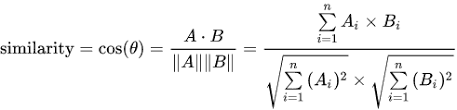

In [10]:
# 유저들(2명) 간 코사인 유사도 계산
def sim_user(user1, user2):
  # 두 유저의 평점을 저장할 리스트
  rating1 = []
  rating2 = []
  
  # 두 사람이 모두 본 영화만 리스트로 저장
  for movie_id in ratings[user1]:
    if movie_id in ratings[user2]:
      rating1.append(ratings[user1][movie_id])
      rating2.append(ratings[user2][movie_id])
    
  if len(rating1) == 0:
    return 0.0
  
  for x in range(len(rating1)):
    # 각 평점에서 평점의 평균을 빼준다.
    rating1[x] = rating1[x] - means[user1]
    rating2[x] = rating2[x] - means[user2] 

  vec = ((np.linalg.norm(rating1)) * (np.linalg.norm(rating2))) # 두 유저 평점 각각의 표준편차(L2 norm) 곱하기

  if vec != 0.0: # 분모가 0이 아니라면
    sim = np.dot(rating1, rating2) / (vec) # 코사인 유사도 계산
  
    return round(sim, 4) # 소수점 아래 4자리까지 계산후 리턴

  else:
    return 0.0 # 분모가 0이면 계산할 수 없음

In [11]:
# 모든 유저들 간 유사도 계산
def calculate_similarity():
  for i in Train['userId'].unique():
    nei = []
    for j in Train['userId'].unique():
      if i != j: # 서로 다른 유저일 경우만
        nei.append((j, sim_user(i, j)))
                  
    # 유저간 similarity 기준 내림차순으로 정렬            
    nei.sort(key=lambda x: x[1], reverse=True)
    neighbors[i] = nei

In [12]:
calculate_similarity()   # 모든 유저간 유사도 계산해서 저장
print(len(neighbors[2])) # 유저2와 비교되는 다른 모든 유저들 수
print(neighbors[2])

609
[(1, 1.0), (5, 1.0), (19, 1.0), (33, 1.0), (43, 1.0), (82, 1.0), (144, 1.0), (145, 1.0), (155, 1.0), (160, 1.0), (193, 1.0), (213, 1.0), (216, 1.0), (240, 1.0), (341, 1.0), (359, 1.0), (399, 1.0), (468, 1.0), (524, 1.0), (597, 1.0), (51, 1.0), (221, 1.0), (299, 1.0), (426, 1.0), (563, 1.0), (552, 1.0), (14, 1.0), (262, 1.0), (11, 1.0), (244, 1.0), (313, 1.0), (34, 1.0), (301, 1.0), (361, 1.0), (387, 1.0), (520, 1.0), (187, 1.0), (427, 1.0), (379, 1.0), (115, 1.0), (36, 1.0), (260, 1.0), (267, 1.0), (375, 1.0), (316, 1.0), (13, 1.0), (129, 1.0), (505, 1.0), (29, 1.0), (329, 1.0), (338, 1.0), (454, 1.0), (491, 1.0), (164, 1.0), (494, 1.0), (168, 1.0), (285, 1.0), (37, 1.0), (101, 1.0), (407, 1.0), (172, 1.0), (190, 1.0), (333, 1.0), (143, 1.0), (598, 1.0), (496, 1.0), (376, 0.9903), (280, 0.9873), (306, 0.9214), (460, 0.9104), (125, 0.8348), (223, 0.8279), (428, 0.8232), (246, 0.7845), (93, 0.7646), (405, 0.7592), (45, 0.7359), (226, 0.7359), (471, 0.7359), (196, 0.7359), (91, 0.7334

## KNN with Means 공식
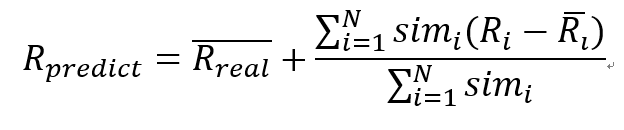

In [13]:
# 아직 평점을 매기지 않은 영화에 대해 평점 예측
def predict_rating(user_id, movie_id):
  rating = 0
  K = 0
  j = 0
  for i in range(N_user - 1):
    # valid neighbor는 40명까지 참고
    if j > 40:
      break
    # 해당 영화 평점을 실제로 매긴 neighbor 유저만 취급
    if movie_id in ratings[neighbors[user_id][i][0]]:
      j += 1
      nei_id = neighbors[user_id][i][0]
      nei_sim = neighbors[user_id][i][1]
      # 평점을 평균값 기준으로 가중 평균하는 공식(KNN with KMeans)
      rating += (ratings[nei_id][movie_id] - means[nei_id]) * nei_sim
      K += nei_sim
  
  if K != 0:
    rating = means[user_id] + (rating / K)
  else: # 유저 간 유사도가 0인 경우, 즉 현재 userId와 비슷한 유저가 1명도 없는 경우(가능성 小)
    rating = -1
  return rating

In [14]:
print(predict_rating(1, 1)) # movieId 1번에 대한 userId 1의 예측 평점
print(predict_rating(1, 2))

4.483428238188908
4.092429309764392


In [18]:
# 테스트셋을 대상으로 평점 예측 지표 구하기
def prediction(test_data):
  test = test_data[['userId', 'movieId', 'rating']]
  test = np.array(test)
  
  sqaure = 0
  avg = 0 
  # 1) RMSE, 2) MAE
  # 평점을 부여한 사람만 에러를 구하는 것 -> 즉 평점을 부여하지 않은 아이템에 대해선 계산하지 않는다
  for user_id, movie_id, rating in test:
    sqaure += (predict_rating(user_id, movie_id) - rating) ** 2 # sum of (아이템의 예측 평점 - 아이템의 원래 평점) ** 2
    avg += abs(predict_rating(user_id, movie_id) - rating)
  return np.sqrt(sqaure / len(test)), avg/len(test)

In [19]:
rmse, mae = prediction(Val)
print("RMSE: ", rmse) # rmmse가 상당히 높은데 참고한 블로그에선 약 0.98 -> 데이터셋의 형태가 매우 중요한 듯 보임(실제로 사용자 기반 협업 필터링은 데이터 영향을 많이 받음)
print("MAE: ", mae)

RMSE:  66.25378438746938
MAE:  1.5823782632689567
